# Analysis of the speedups provided by similarity search module

In this notebook, we will explore the gains in time and memory of the different methods we use in the similarity search module.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from aeon.utils.numba.general import sliding_mean_std_one_series

## Computing means and standard deviations for all subsequences

When we want to compute a normalized distance, given a time series `X` of size `m` and a query `q` of size `l`, we have to compute the mean and standard deviation for all subsequences of size `l` in `X`. One could do this task by doing the following:

In [2]:
def rolling_window_stride_trick(X, window):
    """
    Use strides to generate rolling/sliding windows for a numpy array.
    Parameters
    ----------
    X : numpy.ndarray
        numpy array
    window : int
        Size of the rolling window
    Returns
    -------
    output : numpy.ndarray
        This will be a new view of the original input array.
    """
    a = np.asarray(X)
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def get_means_stds(X, q_length):
    windows = rolling_window_stride_trick(X, q_length)
    return windows.mean(axis=-1), windows.std(axis=-1)


rng = np.random.default_rng()
size = 100
q_length = 10

# Create a random series with 1 feature and 'size' timesteps
X = rng.random((1, size))
means, stds = get_means_stds(X, q_length)
print(means.shape)

(1, 91)


One issue with this code is that it actually recompute a lot of information between the computation of mean and std of each windows. Suppose that the window we compute the mean for `W_i = {x_i, ..., x_{i+(l-1)}`, to do this, we sum all the elements and divide them by `l`. You then want to compute the mean for `W_{i+1} = {x_{i+1}, ..., x_{i+1+(l-1)}`, which shares most of its values with `W_i` expect for `x_i` and `x_{i+1+(l-1)`. 

The optimization here consists in keeping a rolling sum, we only compute the full sum of the `l` values for the first window `W_0`, then to obtain the sum for `W_1`, we remove `x_0` and add `x_{1+(l-1)}` from the sum of `W_0`. We can also a rolling squared sum to compute the standard deviation.

The `sliding_mean_std_one_series` function implement the computation of the means and standard deviations using these two rolling sums. The last argument indicates the dilation to apply to the subsequence, which is not used here, hence the value of 1 in the code bellow.

In [3]:
sizes = [500, 1000, 5000, 10000, 50000]
q_lengths = [50, 100, 250, 500]
times = pd.DataFrame(
    index=pd.MultiIndex(levels=[[], []], codes=[[], []], names=["size", "q_length"])
)
# A first run for numba compilations if needed
sliding_mean_std_one_series(rng.random((1, 50)), 10, 1)
for size in sizes:
    for q_length in q_lengths:
        X = rng.random((1, size))
        _times = %timeit -r 7 -n 10 -q -o get_means_stds(X, q_length)
        times.loc[(size, q_length), "full computation"] = _times.average
        _times = %timeit -r 7 -n 10 -q -o sliding_mean_std_one_series(X, q_length, 1)
        times.loc[(size, q_length), "sliding_computation"] = _times.average

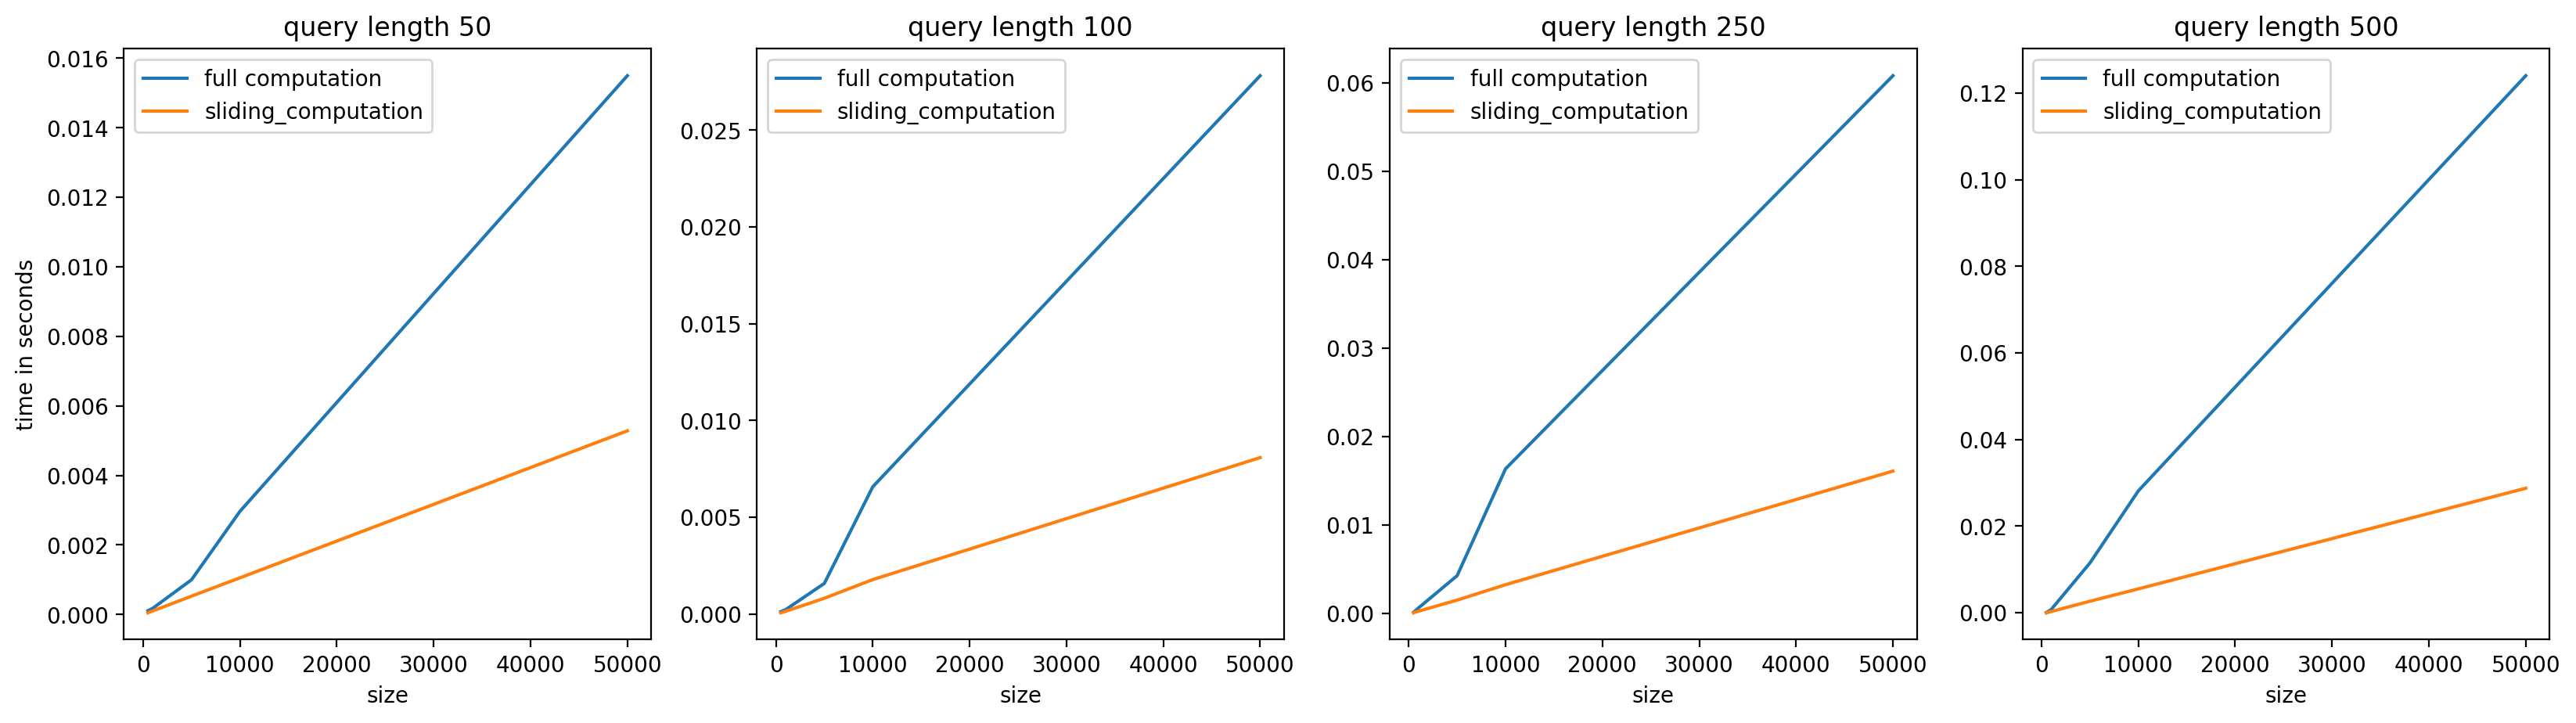

In [4]:
fig, ax = plt.subplots(ncols=len(q_lengths), figsize=(20, 5), dpi=200)
for j, (i, grp) in enumerate(times.groupby("q_length")):
    grp.droplevel(1).plot(label=i, ax=ax[j])
    ax[j].set_title(f"query length {i}")
ax[0].set_ylabel("time in seconds")
plt.show()

As you can see, the larger the size of `q`, the greater the speedups. This is because the larger the size of `q`, the more recomputation we avoid by using a sliding sum.